![image.png](attachment:image.png)

## PRACTICA OBLIGATORIA: **Introducción Deep Learning**

* La práctica obligatoria de esta unidad consiste en un único ejercicio de modelado del dataset del titanic empleando y comparando dos modelos diferentes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo.
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix

### Descripción y objetivo

El objetivo de la práctica es crear un modelo DL y compararlo con un modelo Random Forest para el dataset de titanic los dos con el mismo objetivo, predecir la supervivencia de un pasajero.  Se pide:  
1. Desarrollar el proceso de ML hasta crear los dos modelos DL y Random Forest. El primero debe tener una topología MLP (es decir una red densa) con un máximo de 3 capas ocultas y debes emplear sklearn para crearlo. No es necesario hacer una análisis/seleccion exahustivo. Escoge una métrica acorde al tipo de target del problema.

2. Ambos modelos deben tener sus hiperparámetros optimizados, mediante GridSearch. Para ello: utiliza el grid de parámetros que creas conveniente para Random Forest y para el modelo DL, utiliza un grid con los hiperparámetros siguientes:'hidden_layer_sizes','activation', 'solver','alpha' y 'learning_rate'. Para los rangos del grid del modelo de DL guíate por lo visto en el workout y por los posibles valores que se indican en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier). Prueba por lo menos una topología con una sola capa oculta y otra con más de una capa oculta.   
NOTA: Incluye los valores por defecto de los hiperparámetros escogidos en cada caso dentro del grid de hiperparámetros.
  

3. Compara los modelos respecto a sus métricas medias de accuracy, precision, recall y tiempos de entrenamiento (para ello tendrás que realizar un entrenamiento a parte del mejor modelo obtenido en la optimización de hiperparámetros) y decide cuál te quedarías argumentándolo.    

4. Para el mejor modelo DL obtenido, muestra su clasification report, y la matriz de confusión comentando el resultado.


In [2]:
df_titanic = pd.read_csv('./data/titanic.csv')
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


In [3]:
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
set_train, set_test = train_test_split(df_titanic, test_size=0.2, random_state=42)

In [5]:
for df in [set_train, set_test]:
    age_mean = df.groupby('who')['age'].mean()
    for who in ['child','man','woman']:
        df.loc[(df.age.isnull()) & (df.who == who), 'age'] = age_mean[who]

    df['familiar'] = df.sibsp + df.parch

    df.drop(columns='deck', inplace=True)
    df.dropna(inplace=True)

set_train = pd.get_dummies(set_train, columns=['who','embark_town'], dtype=int)
set_test = pd.get_dummies(set_test, columns=['who','embark_town'], dtype=int)

In [6]:
set_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 710 entries, 331 to 102
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   survived                 710 non-null    int64  
 1   pclass                   710 non-null    int64  
 2   sex                      710 non-null    object 
 3   age                      710 non-null    float64
 4   sibsp                    710 non-null    int64  
 5   parch                    710 non-null    int64  
 6   fare                     710 non-null    float64
 7   embarked                 710 non-null    object 
 8   class                    710 non-null    object 
 9   adult_male               710 non-null    bool   
 10  alive                    710 non-null    object 
 11  alone                    710 non-null    bool   
 12  familiar                 710 non-null    int64  
 13  who_child                710 non-null    int64  
 14  who_man                  710 

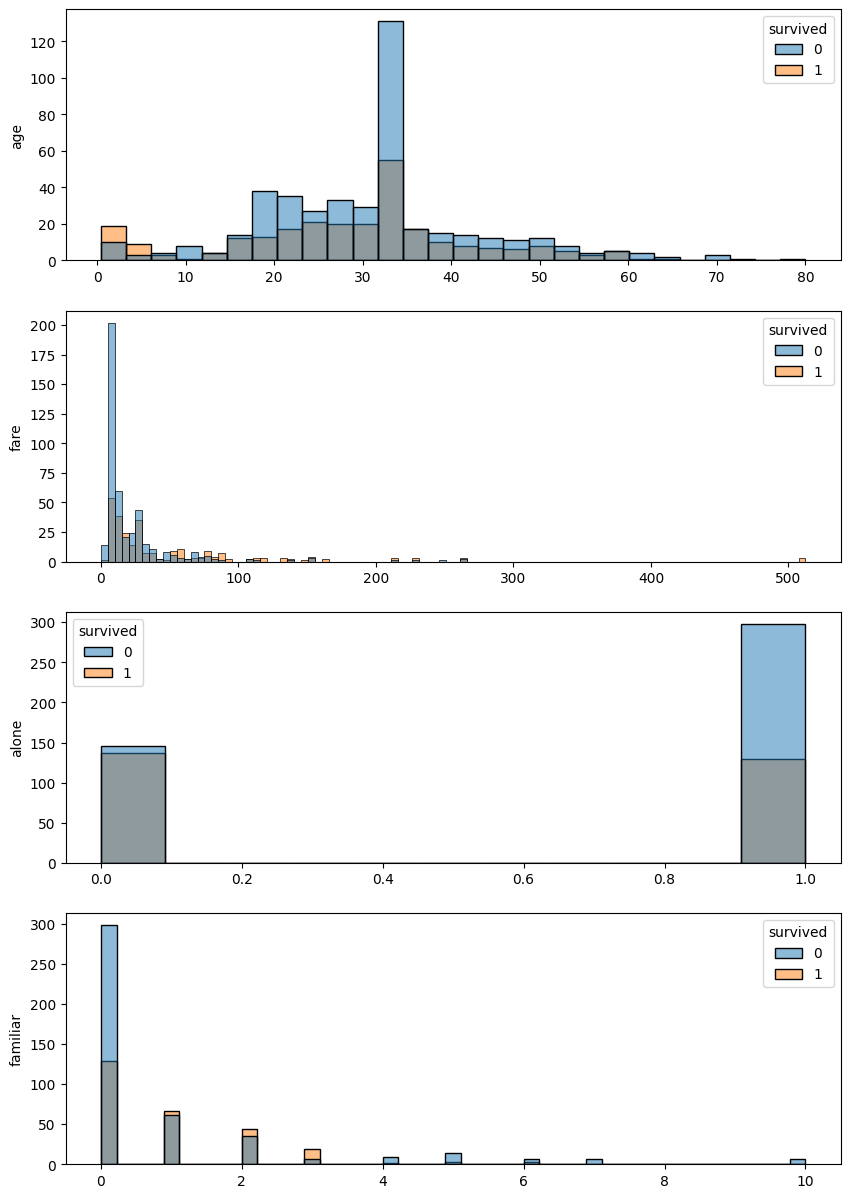

In [7]:
set_train = set_train[['survived', 'pclass', 'age', 'fare','alone', 'familiar',
       'who_child', 'who_man', 'who_woman', 'embark_town_Cherbourg',
       'embark_town_Queenstown', 'embark_town_Southampton']]
features_num = ['age', 'fare','alone', 'familiar']

fig, ax = plt.subplots(len(features_num),1, figsize=(10,15))
for index, feature in enumerate(features_num):
    sns.histplot(set_train, x=feature, hue='survived', ax=ax[index])
    ax[index].set_xlabel('')
    ax[index].set_ylabel(feature)

In [8]:
set_train.corr()['survived'].abs().sort_values(ascending=False)

survived                   1.000000
who_man                    0.553521
who_woman                  0.508844
pclass                     0.317806
fare                       0.244187
alone                      0.184088
embark_town_Cherbourg      0.161731
embark_town_Southampton    0.137159
who_child                  0.129174
age                        0.076438
familiar                   0.005591
embark_town_Queenstown     0.005010
Name: survived, dtype: float64

In [9]:
# Viendo la distribución de los gráficos y las correlaciones
# Eliminamos las variables con correlación < 0.1

set_train.drop(columns=['age','familiar','embark_town_Queenstown'], inplace=True)
set_test = set_test[list(set_train.columns)]

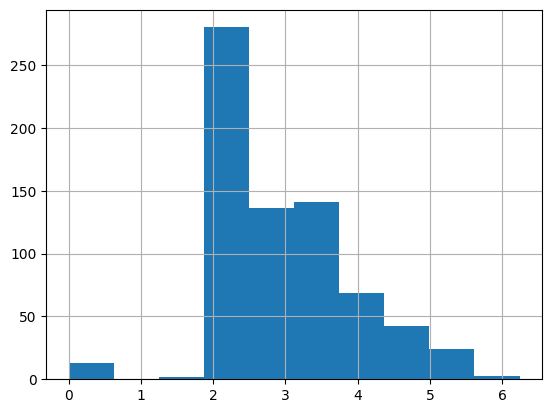

In [10]:
# Echamos otros vistazo a fare

np.log1p(set_train.fare).hist();

In [11]:
# Y trnsformamos

set_train.fare = np.log1p(set_train.fare)
set_test.fare = np.log1p(set_test.fare)

In [12]:
target = 'survived'

X_train = set_train.drop(columns=[target])
y_train = set_train[target]

X_test = set_test.drop(columns=[target])
y_test = set_test[target]

In [13]:
# Echemos un vistazo a la distribución del target, cosa que aún no hice,
# y constatamos que el dataset está desbalanceado, por lo que emplearemos como métrica 'accuracy balance'

y_train.value_counts(True)

survived
0    0.625352
1    0.374648
Name: proportion, dtype: float64

#### Random Forest

In [ ]:
rforest = RandomForestClassifier(random_state=42)
params = {
    'n_estimators':[100, 300],
    'max_depth':[10, 30, 50],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf':[1, 3],
    'class_weight':['balanced','balanced_subsample'],
    'criterion': ['gini', 'entropy', 'log_loss']
}

rforest_grid = GridSearchCV(estimator=rforest, param_grid=params, cv=5, scoring='balanced_accuracy', n_jobs=-1)

start = time.time()
rforest_grid.fit(X_train, y_train)
end = time.time()

grid_time = end - start
rforest_grid.best_estimator_

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       min_samples_split=10, random_state=42)

Resultado grid

In [ ]:
grid = rforest_grid
print(f'RandomForest - {grid_time // 60} min {grid_time % 60} s')
print(f'Balancd accuracy: {grid.best_score_}')
pd.DataFrame({'Params':grid.best_params_.keys(), 'Values':grid.best_params_.values()})

RandomForest - 2.0 min 8.326029062271118 s
Balancd accuracy: 0.7917477991704196


,Params,Values
0,class_weight,balanced_subsample
1,criterion,gini
2,max_depth,10
3,min_samples_leaf,1
4,min_samples_split,10
5,n_estimators,100


Evaluación modelo

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       105
           1       0.78      0.80      0.79        74

    accuracy                           0.82       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.82      0.82      0.82       179



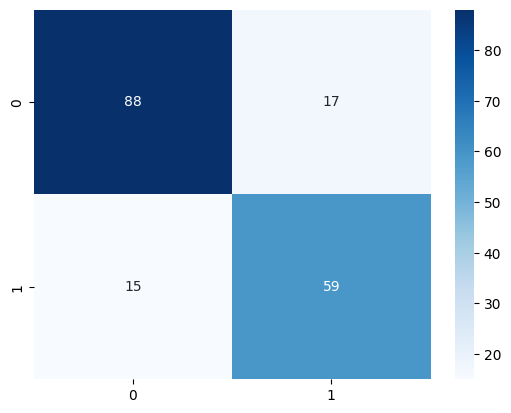

In [17]:
best = grid.best_estimator_
y_pred = best.predict(X_test)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues');

#### Multi-Layer Perceptron

In [20]:
mlp = MLPClassifier(random_state=42)

params = {
    'hidden_layer_sizes':[(100,), (100,100)],
    'activation':['logistic','relu'],
    'solver':['lbfgs','adam'],
    'alpha':[0.0001, 0.001, 0.1],
    'learning_rate':['constant','invscaling']
}

mlp_grid = GridSearchCV(estimator=mlp, param_grid=params, cv=5, scoring='balanced_accuracy', n_jobs=-1)

start = time.time()
mlp_grid.fit(X_train, y_train)
end = time.time()

grid_time = end - start
mlp_grid.best_estimator_

MLPClassifier(activation='logistic', alpha=0.1, random_state=42)

Resultado grid

In [21]:
grid = mlp_grid
print(f'RandomForest - {grid_time // 60} min {grid_time % 60} s')
print(f'Balancd accuracy: {grid.best_score_}')
pd.DataFrame({'Params':grid.best_params_.keys(), 'Values':grid.best_params_.values()})

RandomForest - 1.0 min 16.45341658592224 s
Balancd accuracy: 0.7868848277132143


,Params,Values
0,activation,logistic
1,alpha,0.1
2,hidden_layer_sizes,"(100,)"
3,learning_rate,constant
4,solver,adam


Evaluación modelo

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       105
           1       0.71      0.74      0.73        74

    accuracy                           0.77       179
   macro avg       0.76      0.77      0.77       179
weighted avg       0.77      0.77      0.77       179



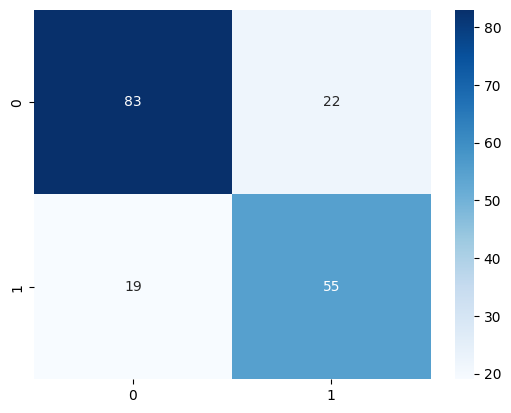

In [22]:
best = grid.best_estimator_
y_pred = best.predict(X_test)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues');

El MLP ha sido la mitad de rápido que RandomForest, aunque RandomForest ha conseguido un mejor acierto, posiblemente por una mejor optimización. Dicho esto, a pesar de la rapidez de MLP, seguiría con RandomForest, al ser más explicable y menos complejo de optimizar.